# FFNN
Training auf IDS17 80%  
Validierung auf IDS17 10%   
Test auf IDS17 10%  
Test auf IDS18 folgt in nächstem Skript

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

2024-11-23 19:50:00.259738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 19:50:00.321905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 19:50:00.353541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 19:50:00.360898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 19:50:00.403691: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(ids17_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-23 19:50:02 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64


(1923063, 51)
Index(['Total TCP Flow Time', 'Fwd IAT Total', 'Fwd Header Length', 'Idle Std',
       'Bwd Header Length', 'Dst Port', 'ECE Flag Count', 'Fwd IAT Max',
       'Fwd Packet Length Max', 'Fwd PSH Flags', 'Fwd Bulk Rate Avg',
       'Protocol', 'Bwd Packet Length Min', 'Bwd Init Win Bytes',
       'Flow Bytes/s', 'Fwd IAT Mean', 'FWD Init Win Bytes',
       'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Bwd IAT Std',
       'Bwd IAT Min', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
       'Bwd Packet Length Std', 'Bwd URG Flags', 'Flow IAT Mean',
       'Fwd IAT Min', 'Subflow Bwd Packets', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Bwd PSH Flags', 'Flow IAT Max', 'FIN Flag Count',
       'SYN Flag Count', 'Bwd IAT Total', 'Bwd Segment Size Avg',
       'Down/Up Ratio', 'Total Fwd Packet', 'Packet Length Variance',
       'Fwd URG Flags', 'Flow IAT Min', 'Active Min', 'Bwd IAT Mean',
       'Bwd Packets/s', 'Bwd RST Flags', 'RST Flag Count', 'Active Std',
       'S

### Trennen von Features und Labels

In [4]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923063, 50)
Form von y: (1923063,)


### Label Encoding für y

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [6]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (1538450, 50)
Form von X_val: (192306, 50)
Form von X_test: (192307, 50)


### Skallierung von X

In [7]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Überprüfen der Klassenverteilung

In [8]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1266048 Beispiele (82.29%)
  Klasse 1: 589 Beispiele (0.04%)
  Klasse 2: 76115 Beispiele (4.95%)
  Klasse 3: 6054 Beispiele (0.39%)
  Klasse 4: 126774 Beispiele (8.24%)
  Klasse 5: 3087 Beispiele (0.20%)
  Klasse 6: 57414 Beispiele (3.73%)
  Klasse 7: 2369 Beispiele (0.15%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 158256 Beispiele (82.29%)
  Klasse 1: 74 Beispiele (0.04%)
  Klasse 2: 9514 Beispiele (4.95%)
  Klasse 3: 757 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7176 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 158257 Beispiele (82.29%)
  Klasse 1: 73 Beispiele (0.04%)
  Klasse 2: 9515 Beispiele (4.95%)
  Klasse 3: 756 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7177 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)



 ### Modell erstellen und trainieren

In [9]:
num_features = len(X_train.columns)  # Anzahl der Merkmale
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# Definiere das Modell
model = Sequential([
    InputLayer(shape=(num_features,), name = 'Input-Layer'),  # Eingabeschicht
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), name = 'Dense-Layer-1'),  # Erste versteckte Schicht mit l2-Regularisierung
    Dropout(0.3, name = 'Dropout-Layer'),  # Vermeidung von Overfitting
    Dense(32, activation='relu', name = 'Dense-Layer-2'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax', name = 'Output-Layer')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



I0000 00:00:1732387811.336912 1317627 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732387811.468631 1317627 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732387811.468672 1317627 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732387811.471985 1317627 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732387811.472028 1317627 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-Layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-2 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,608 (21.91 KB)

 Trainable params: 5,608 (21.91 KB)

 Non-trainable params: 0 (0.00 B)

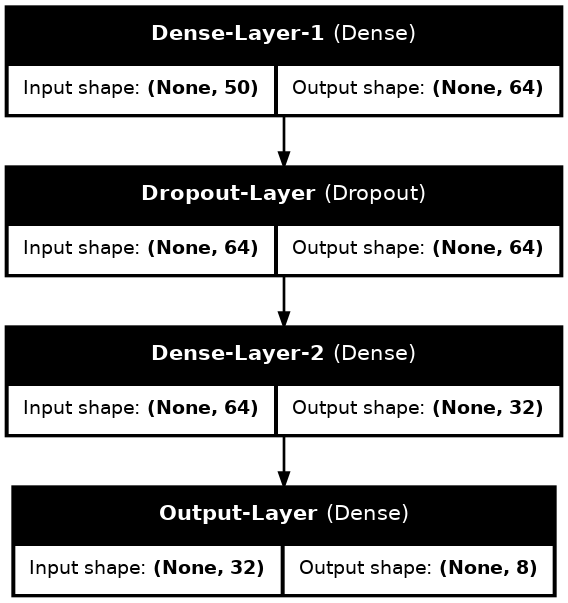

In [10]:
# Modell visualisieren und als PNG speichern
plot_model(
    model, 
    to_file='model_structure.png',  # Speicherort der Grafik
    show_shapes=True,  # Zeigt die Form der Tensoren an
    show_layer_names=True,  # Zeigt die Namen der Schichten an
    dpi=96  # Auflösung
)


### Trainieren des Modells

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1732387813.200263 1317830 service.cc:146] XLA service 0x7f1b8c0052e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732387813.200357 1317830 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-23 19:50:13.225652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 19:50:13.318002: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  136/48077 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 1.1866 - sparse_categorical_accuracy: 0.7069

I0000 00:00:1732387814.040912 1317830 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48077/48077 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9985
Epoch 2/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0125 - val_sparse_categorical_accuracy: 0.9988
Epoch 3/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0118 - val_sparse_categorical_accuracy: 0.9988
Epoch 4/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0111 - val_sparse_categorical_accuracy: 0.9989
Epoch 5/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0117 - val_sparse_categorical_accuracy: 0.9988
Epoch 6/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0109 - val_sparse_categorical_ac

### Trainingsverlauf plotten

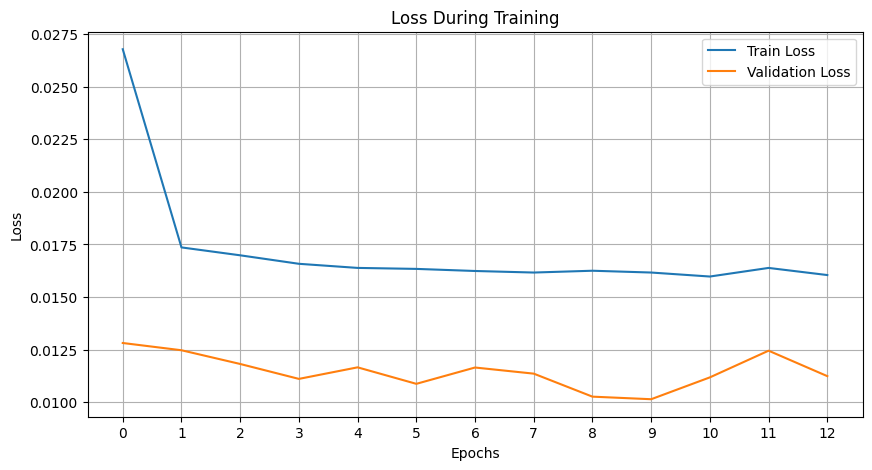

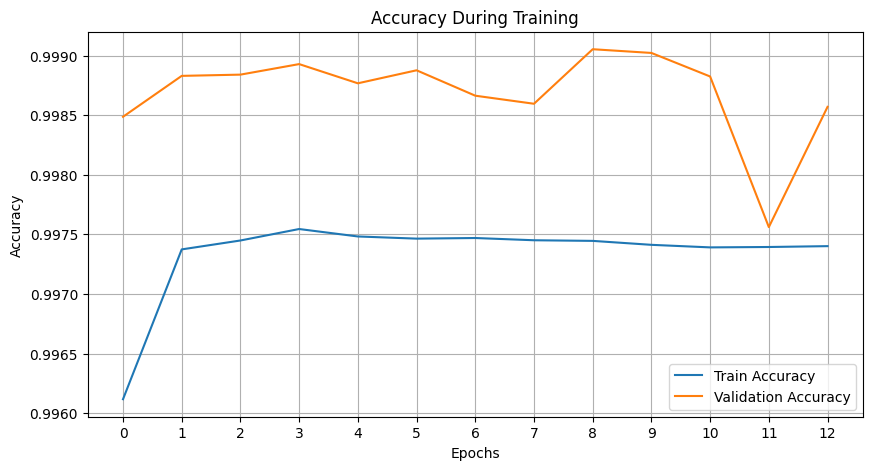

In [12]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz

#### Klassifikationsbericht und Konfusionsmatrix

In [13]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

6010/6010 ━━━━━━━━━━━━━━━━━━━━ 5s 727us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    158257
                 Botnet Ares       1.00      0.92      0.96        73
              DDoS-LOIC-HTTP       1.00      1.00      1.00      9515
               DoS GoldenEye       0.97      0.99      0.98       756
                    DoS Hulk       1.00      1.00      1.00     15847
               DoS Slowloris       0.98      0.91      0.95       386
Infiltration - NMAP Portscan       1.00      0.99      0.99      7177
              SSH-BruteForce       0.99      1.00      0.99       296

                    accuracy                           1.00    192307
                   macro avg       0.99      0.98      0.98    192307
                weighted avg       1.00      1.00      1.00    192307



Visualisierung der Konfusionsmatrix

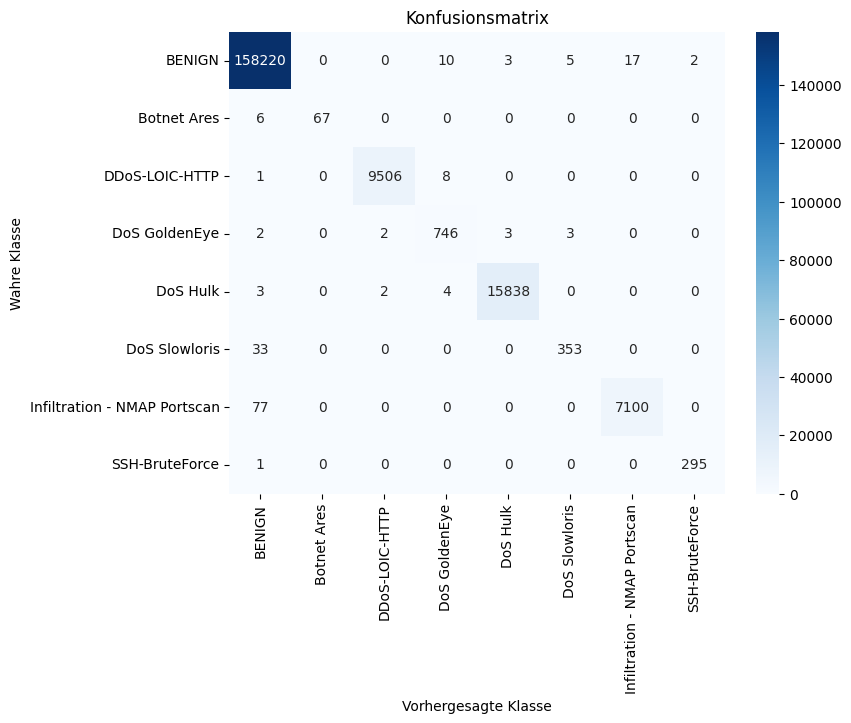

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern von Modell, Encoder und Scaler

In [15]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']